### 베이스라인 모델 : 단순 회귀
- 목적  
    - 비교를 위한 베이스라인( 비교대상 ) 모델 생성 
- 내용
    - target값의 분포를 확인하여 특정 한 곳에 집중되어있다면 log화
    - 성능을 개선시키기위해 지속적인 비교가 필요

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from ipywidgets import interact
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")
plt.rc("font",family="Malgun Gothic")
plt.rc("axes",unicode_minus=False)
plt.style.use("fivethirtyeight")



plt.style.use('ggplot')

project_ID= 'new-york-taxi-309501'

 #### 전처리


In [2]:
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='new-york-taxi-309501')

Downloading: 100%|██████████████████████████████████████████████████████████| 87020/87020 [00:05<00:00, 17123.06rows/s]


In [3]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(base_df[['zip_code']])
ohe_output = ohe.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df,pd.DataFrame(ohe_output, columns= 'zip_code_'+ohe.categories_[0])],axis=1)
ohe_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,10037,2015-01-01,1,1,3,0,0,26,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10039,2015-01-01,1,1,3,0,0,9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11105,2015-01-01,1,1,3,0,0,32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11238,2015-01-01,1,1,3,0,0,95,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11203,2015-01-01,1,1,3,0,0,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def train_test_split(df,date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

#### Linear Regerssion
- 베이스라인 모델 : 비교대상

#### target값 분포 확인


In [5]:
base_df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10037,2015-01-01 00:00:00,1,1,3,0,0,26
1,10039,2015-01-01 00:00:00,1,1,3,0,0,9
2,11105,2015-01-01 00:00:00,1,1,3,0,0,32
3,11238,2015-01-01 00:00:00,1,1,3,0,0,95
4,11203,2015-01-01 00:00:00,1,1,3,0,0,3
...,...,...,...,...,...,...,...,...
87015,10044,2015-01-31 23:00:00,1,31,5,23,1,6
87016,10009,2015-01-31 23:00:00,1,31,5,23,1,1166
87017,10020,2015-01-31 23:00:00,1,31,5,23,1,66
87018,11102,2015-01-31 23:00:00,1,31,5,23,1,23


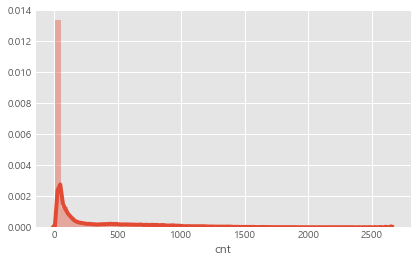

In [6]:
sns.distplot(base_df['cnt'])

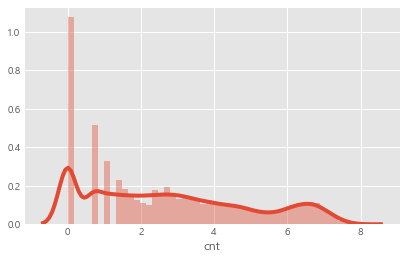

In [7]:
sns.distplot(np.log(base_df['cnt']))

#### widget 활용

In [8]:
def visualize_dist_zip_code(df, log=False):
    def view_images(zip_code):
        if log:
            data = np.log10(df.loc[df['zip_code'] == str(zip_code)]['cnt'])
        else:
            data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        ax = sns.distplot(data)
#         ax.set_tilte(f'log is {log}, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001,10200))

In [9]:
visualize_dist_zip_code(ohe_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

In [10]:
visualize_dist_zip_code(base_df,log=True)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

In [11]:
def visualize_dist_by_zipcode_at_the_same_time(df):
    def view_images(zip_code):
        fig, ax = plt.subplots(ncols=2,figsize=(15,5))
        
        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        raw = sns.distplot(raw_data, ax = ax[0])
        log = sns.distplot(log_data, ax = ax[1])
        raw.set_title(f'원본 데이터, zip_code : {zip_code}')
        log.set_title(f'로그 데이터, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))  

In [12]:
visualize_dist_by_zipcode_at_the_same_time(base_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

In [13]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

#### train /test 데이터 나누기

In [19]:
train_df, test_df = train_test_split(base_df, '2015-01-24')

In [21]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10037,2015-01-01,1,1,3,0,0,26,1.414973
1,10039,2015-01-01,1,1,3,0,0,9,0.954243
2,11105,2015-01-01,1,1,3,0,0,32,1.505150
3,11238,2015-01-01,1,1,3,0,0,95,1.977724
4,11203,2015-01-01,1,1,3,0,0,3,0.477121


In [22]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65118,10451,2015-01-24,1,24,5,0,1,3,0.477121
65119,10069,2015-01-24,1,24,5,0,1,7,0.845098
65120,10038,2015-01-24,1,24,5,0,1,145,2.161368
65121,10280,2015-01-24,1,24,5,0,1,26,1.414973
65122,10025,2015-01-24,1,24,5,0,1,332,2.521138


In [23]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [24]:
train_df.head(2)

,zip_code,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10037,1,1,3,0,0,26,1.414973
1,10039,1,1,3,0,0,9,0.954243


In [25]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
x_train = train_df.copy()
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')
x_test = test_df.copy()